In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jun 10 15:40:22 2019

@author: athomas7
"""

'\nCreated on Mon Jun 10 15:40:22 2019\n\n@author: athomas7\n'

In [2]:
"""
train_file = "C:/SEPP19/Eye Tracking/Single Eye/train + test.zip"

import zipfile

zf = zipfile.ZipFile(train_file)
zf.extractall()
"""

'\ntrain_file = "C:/SEPP19/Eye Tracking/Single Eye/train + test.zip"\n\nimport zipfile\n\nzf = zipfile.ZipFile(train_file)\nzf.extractall()\n'

In [132]:
import os
import cv2
import tempfile

def load_image(file_path):
    return cv2.imread(file_path)

def extract_label(file_name):
    return 1 if "open" in file_name else 0 # open eyes are 1 & closed eyes are 0

train_path = "C:/Users/Z/Desktop/begintrain/"

image_files = os.listdir(train_path)
train_images = [load_image(train_path + file) for file in image_files]
train_labels = [extract_label(file) for file in image_files]

In [133]:
# this will probably not be an issue with the real deal, since all images will be the same size
# so we can re-train with that view from the pilot's eye from the instrument...
def preprocess_image(img, side = 28): # number of pixels on the smallest side
    # average eye aspect ratio is 1.87 by 1 (it requires an int, so I rounded 1.87 to 2)
    eye_aspect_ratio = 1
    min_side = min(img.shape[0], img.shape[1])
    img = img[:min_side, :min_side * eye_aspect_ratio]
    img = cv2.resize(img, (side * eye_aspect_ratio, side)) # average eye aspect ratio of 1.87 by 1
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img / 255.0

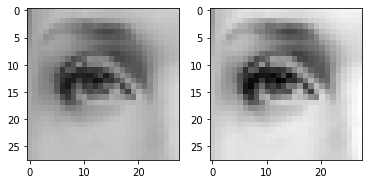

In [134]:
import matplotlib.pyplot as plt
# %matplotlib inline
preview_index = 186
plt.subplot(1,2,1)
plt.imshow(train_images[preview_index])
plt.subplot(1,2,2)
plt.imshow(preprocess_image(train_images[preview_index]), cmap="gray")
# some images are showing up wonky here b/c of your aspect ratio side multiplier ^^^
# it does allow to get the entire eye within the frame though so worth it...
# looks weird to us but the neural net will understand

In [135]:
for i in range(len(train_images)):
    train_images[i] = preprocess_image(train_images[i])

In [136]:
import numpy as np

train_images = np.expand_dims(train_images, axis = -1)
train_labels = np.array(train_labels)

In [137]:
print(train_images.shape, train_labels.shape)

(187, 28, 28, 1) (187,)


In [144]:
import tensorflow as tf
print("Tensorflow:", tf.__version__)

layers = [
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=tf.nn.relu, input_shape=train_images.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=tf.nn.relu, input_shape=train_images.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=tf.nn.relu, input_shape=train_images.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=tf.nn.relu, input_shape=train_images.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
#     tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=tf.nn.relu, input_shape=train_images.shape[1:]),
#     tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=256, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=2, activation=tf.nn.softmax) # probability for each of the classes (2 as of now)
]

# https://keras.io/optimizers/ (see Adam section)
# https://keras.io/losses/ (see sparse_categorical_accuracy)
model = tf.keras.Sequential(layers)
model.compile(optimizer='adam',
              # optimizer=tf.keras.optimizers.Adam(),
              # loss='binary_crossentropy',
              # loss=tf.losses.sparse_softmax_cross_entropy(),
              # loss=tf.keras.backend.sparse_categorical_crossentropy(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              # metrics=[tf.metrics.accuracy()])
""" TensorFlow 2.0.0 Beta
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.metrics.SparseCategoricalAccuracy()])
"""

Tensorflow: 2.2.0-dev20200304


' TensorFlow 2.0.0 Beta\nmodel.compile(optimizer=tf.optimizers.Adam(),\n              loss=tf.losses.SparseCategoricalCrossentropy(),\n              metrics=[tf.metrics.SparseCategoricalAccuracy()])\n'

In [145]:
logdir = tempfile.mkdtemp()

In [146]:
# Training the model
model.fit(train_images, train_labels, epochs=10, batch_size=50)
# model.save_weights("model.tf")
model.save("model.h5")

Epoch 1/10
4/4 [==============================] - 0s 22ms/step - loss: 0.6919 - accuracy: 0.5080
Epoch 2/10
4/4 [==============================] - 0s 17ms/step - loss: 0.6801 - accuracy: 0.6684
Epoch 3/10
4/4 [==============================] - 0s 16ms/step - loss: 0.6471 - accuracy: 0.6257
Epoch 4/10
4/4 [==============================] - 0s 17ms/step - loss: 0.6112 - accuracy: 0.6791
Epoch 5/10
4/4 [==============================] - 0s 18ms/step - loss: 0.5464 - accuracy: 0.6952
Epoch 6/10
4/4 [==============================] - 0s 17ms/step - loss: 0.5027 - accuracy: 0.7754
Epoch 7/10
4/4 [==============================] - 0s 18ms/step - loss: 0.3814 - accuracy: 0.8610
Epoch 8/10
4/4 [==============================] - 0s 19ms/step - loss: 0.3372 - accuracy: 0.8663
Epoch 9/10
4/4 [==============================] - 0s 19ms/step - loss: 0.2757 - accuracy: 0.8984
Epoch 10/10
4/4 [==============================] - 0s 17ms/step - loss: 0.2470 - accuracy: 0.9091


In [147]:
import pickle
import cv2

test_file = "closed_eye_1.jpg"
uploads = cv2.imread("../datasets/eyes/train_blink_data/" + test_file)

""" For Multiple Images...
import glob
import cv2
images = [cv2.imread(file) for file in glob.glob("path/to/files/*.png")]
"""

eval_images = [preprocess_image(uploads)] # must be an array because of the for-loop below
# eval_images = [preprocess_image(load_image(file)) for file in uploads].keys()]
eval_model = tf.keras.Sequential(layers)
eval_model.load_weights("model.h5")
eval_predictions = eval_model.predict(np.expand_dims(eval_images, axis = -1))

cols = 4
rows = np.ceil(len(eval_images)/cols)
fig = plt.gcf()
fig.set_size_inches(cols*4, rows*4)
for i in range(len(eval_images)):
    plt.subplot(rows, cols, i+1)
    plt.imshow(eval_images[i], cmap="gray")
    plt.title("Open" if np.argmax(eval_predictions[i])==1 else "Closed")
    plt.axis('off')

AttributeError: 'NoneType' object has no attribute 'shape'

In [148]:
print(train_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


In [149]:
import numpy as np
img_arr = np.array(preprocess_image(uploads))
print(len(img_arr.flatten()))

AttributeError: 'NoneType' object has no attribute 'shape'

In [150]:
# Backend agnostic way to save/restore models
_, keras_file = tempfile.mkstemp('.h5')
print('Saving model to: ', keras_file)
tf.keras.models.save_model(model, keras_file, include_optimizer=False)

Saving model to:  C:\Users\Z\AppData\Local\Temp\tmpppfnogf4.h5
